In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

/home/rahovegas/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/rahovegas/.cache/kagglehub/datasets/moltean/fruits/versions/11


In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import pickle

%matplotlib inline
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

/home/rahovegas/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
def getYourFruits(directory_path, fruits, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']
    if not k_fold:
        path = f"{directory_path}/*/fruits-360/" + data_type + "/"
        for i,f in enumerate(fruits):
            p = path + f
            j=0
            for image_path in glob.glob(os.path.join(p, "*.jpg")):
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                images.append(image)
                labels.append(i)
                j+=1
            if(print_n):
                print("There are " , j , " " , data_type.upper(), " images of " , fruits[i].upper())
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            path = f"{directory_path}/*/fruits-360/" + v + "/"
            for i,f in enumerate(fruits):
                p = path + f
                j=0
                for image_path in glob.glob(os.path.join(p, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j+=1
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    
def getAllFruits(directory_path):
    fruits = []
    for fruit_path in glob.glob(f"{directory_path}/*/fruits-360/Training/*"):
        fruit = fruit_path.split("/")[-1]
        fruits.append(fruit)
    return fruits

In [4]:
fruits = getAllFruits(path)
fruits = np.unique(fruits)
print(fruits)

train_imgs, train_labels = getYourFruits(path, fruits, "Training", print_n=True)

test_imgs, test_labels = getYourFruits(path, fruits, "Test", print_n=True)

print(len(train_imgs), len(train_labels), len(test_imgs), len(test_labels))

['Apple 6' 'Apple Braeburn 1' 'Apple Crimson Snow 1' 'Apple Golden 1'
 'Apple Golden 2' 'Apple Golden 3' 'Apple Granny Smith 1'
 'Apple Pink Lady 1' 'Apple Red 1' 'Apple Red 2' 'Apple Red 3'
 'Apple Red Delicious 1' 'Apple Red Yellow 1' 'Apple Red Yellow 2'
 'Apple hit 1' 'Apricot 1' 'Avocado 1' 'Avocado ripe 1' 'Banana 1'
 'Banana Lady Finger 1' 'Banana Red 1' 'Beetroot 1' 'Blueberry 1'
 'Cabbage white 1' 'Cactus fruit 1' 'Cantaloupe 1' 'Cantaloupe 2'
 'Carambula 1' 'Carrot 1' 'Cauliflower 1' 'Cherry 1' 'Cherry 2'
 'Cherry Rainier 1' 'Cherry Wax Black 1' 'Cherry Wax Red 1'
 'Cherry Wax Yellow 1' 'Chestnut 1' 'Clementine 1' 'Cocos 1' 'Corn 1'
 'Corn Husk 1' 'Cucumber 1' 'Cucumber 3' 'Cucumber Ripe 1'
 'Cucumber Ripe 2' 'Dates 1' 'Eggplant 1' 'Eggplant long 1' 'Fig 1'
 'Ginger Root 1' 'Granadilla 1' 'Grape Blue 1' 'Grape Pink 1'
 'Grape White 1' 'Grape White 2' 'Grape White 3' 'Grape White 4'
 'Grapefruit Pink 1' 'Grapefruit White 1' 'Guava 1' 'Hazelnut 1'
 'Huckleberry 1' 'Kaki 1' 'Kiw

In [5]:
class DataProcessing:
	def __init__(self, train_data, test_data):
		self.train_data = train_data
		self.test_data = test_data

	def extract_HOG_features(self, imgs, hog_path, n_bins=9):
		if os.path.exists(hog_path):
			return pickle.load(open(hog_path + '/hog_features.pkl', 'rb'))
		
		os.makedirs(hog_path)

		fds = []

		idx = 0

		for img in imgs:
			img_resized = resize(img, (128, 64))
			fd, hog_img = hog(img_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)
			hog_img = resize(hog_img, (100, 100))
			
			pickle.dump(hog_img, open(hog_path + '/hog_img_{}.pkl'.format(idx), 'wb'))
			fds.append(fd)

			idx += 1

		pickle.dump(fds, open(hog_path + '/hog_features.pkl', 'wb'))
		
		return np.array(fds)

	def extract_ORB_features(self, imgs):
		orb = cv2.ORB_create()
		
		orb_kp = []
		orb_des = np.zeros((len(imgs), 32))

		idx = 0

		for img in imgs:
			train_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
			train_kp, train_des = orb.detectAndCompute(train_img, None)

			if train_des is None:
				train_des = np.zeros((1, 32))

			orb_des[idx, :] = np.array([np.mean(train_des, axis=0)])

			idx += 1

			orb_kp.append(train_kp)

		return orb_kp, orb_des

	def collect_and_transform_data(self):
		scaler = StandardScaler()

		train_orb_kp, train_orb_des = self.extract_ORB_features(train_imgs)
		
		train_orb_des = train_orb_des.reshape(train_orb_des.shape[0], -1)

		test_orb_kp, test_orb_des = self.extract_ORB_features(test_imgs)
		test_orb_des = test_orb_des.reshape(test_orb_des.shape[0], -1)

		train_hog = self.extract_HOG_features(train_imgs, 'hog_train', 9)
		
		test_hog = self.extract_HOG_features(test_imgs, 'hog_test', 9)

		X_train = np.concatenate((train_hog, train_orb_des), axis=1)
		X_test = np.concatenate((test_hog, test_orb_des), axis=1)

		print("Number of extracted features after HOG and ORB:", X_train.shape[1])

		sel = VarianceThreshold(threshold=.96 * (1 - .96))
		X_train = sel.fit_transform(X_train)
		X_test = sel.transform(X_test)

		X_train = scaler.fit_transform(X_train)
		X_test = scaler.transform(X_test)

		print("Number of extracted features after variance threshold:", X_train.shape[1])

		return X_train, X_test, train_labels, test_labels

In [6]:
X_train, X_test, y_train, y_test = DataProcessing(train_imgs, test_imgs).collect_and_transform_data()

Number of extracted features after HOG and ORB: 3812
Number of extracted features after variance threshold: 110


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms

In [8]:
class CustomDataset(Dataset):
	def __init__(self, X, y, transform=None):
		self.X = X
		self.y = y
		self.transform = transform

	def __len__(self):
		return len(self.X)

	def __getitem__(self, idx):
		image = self.X[idx]
		label = self.y[idx]

		if self.transform:
			image = self.transform(image)
		else:
			image = torch.tensor(image, dtype=torch.float32)
			
		label = torch.tensor(label, dtype=torch.long)

		return image, label

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def train_epoch(model, dataloader, device, optimizer, criterion, epoch, lr_scheduler=None):
	model.train()

	train_loss = 0.0
	correct = 0
	dataset_size = 0

	for step, (images, labels) in enumerate(dataloader):
		images = images.to(device)
		labels = labels.to(device)

		optimizer.zero_grad()

		pred = model(images)
		loss = criterion(pred, labels)

		predicted = torch.argmax(pred, 1)
		correct += (predicted == labels).sum().item()
		dataset_size += labels.size(0)

		loss.backward()
		optimizer.step()
		if lr_scheduler:
			lr_scheduler.step()

		train_loss += loss.item()

	train_loss /= dataset_size
	accuracy = correct / dataset_size

	return train_loss, accuracy

In [11]:
def valid_epoch(model, dataloader, device, criterion,epoch):
	model.eval()

	valid_loss = 0.0
	correct = 0
	dataset_size = 0

	for step, (images, labels) in enumerate(dataloader):
		images = images.to(device)
		labels = labels.to(device)

		pred = model(images)
		loss = criterion(pred, labels)

		valid_loss += loss.item()

		predicted = torch.argmax(pred, dim=1)
		correct += (predicted == labels).sum().item()
		dataset_size += labels.size(0)

	valid_loss /= dataset_size
	accuracy = correct / dataset_size

	return valid_loss, accuracy

In [12]:
def plot_loss(train_losses, test_losses, title):
	plt.plot(train_losses, label='Training loss')
	plt.plot(test_losses, label='Test loss')
	plt.legend()
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title(title)
	plt.show()

In [13]:
def plot_accuracy(train_accuracy, test_accuracy, title):
	plt.plot(train_accuracy, label='Training accuracy')
	plt.plot(test_accuracy, label='Test accuracy')
	plt.legend()
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy')
	plt.title(title)
	plt.show()

In [14]:
def run_training(model, criterion, optimizer, num_epochs, lr_scheduler=None):
	training_losses = []
	train_accs = []

	test_losses = []
	test_accs = []

	for epoch in range(num_epochs):
		train_loss, train_acc = train_epoch(model, train_loader, device, optimizer, criterion, epoch, lr_scheduler)
	
		training_losses.append(train_loss)
		train_accs.append(train_acc)

		with torch.no_grad():
			test_loss, test_acc = valid_epoch(model, test_loader, device, criterion, epoch)

			test_losses.append(test_loss)
			test_accs.append(test_acc)

			print('Epoch: {} Train Loss: {:.4f} Train Acc: {:.4f} Test Loss: {:.4f} Test Acc: {:.4f}'.format(epoch, train_loss, train_acc, test_loss, test_acc))
	
	plot_loss(training_losses, test_losses, "Loss")
	plot_accuracy(train_accs, test_accs, "Accuracy")
	return training_losses, test_losses, train_accs, test_accs

In [15]:
class FeatureMLPNet(nn.Module):
	def __init__(self):
		super(FeatureMLPNet, self).__init__()
		self.fc1 = nn.Linear(in_features=110, out_features=256)
		self.fc2 = nn.Linear(in_features=256, out_features=512)
		self.fc3 = nn.Linear(in_features=512, out_features=141)

		self.relu = nn.ReLU()

		self.dropout = nn.Dropout(p=0.2)

	def forward(self, x):
		x = self.fc1(x)
		x = self.relu(x)
		x = self.dropout(x)
		x = self.fc2(x)
		x = self.relu(x)
		x = self.dropout(x)
		x = self.fc3(x)
		
		return x


In [16]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Resize((32, 32)),
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [17]:
training_data = CustomDataset(X_train, y_train)
testing_data = CustomDataset(X_test, y_test)

train_loader = DataLoader(training_data, batch_size=256, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=256, shuffle=True)

Epoch: 0 Train Loss: 0.0094 Train Acc: 0.4023 Test Loss: 0.0080 Test Acc: 0.5032
Epoch: 1 Train Loss: 0.0042 Train Acc: 0.6920 Test Loss: 0.0064 Test Acc: 0.6001
Epoch: 2 Train Loss: 0.0029 Train Acc: 0.7834 Test Loss: 0.0057 Test Acc: 0.6334
Epoch: 3 Train Loss: 0.0022 Train Acc: 0.8279 Test Loss: 0.0054 Test Acc: 0.6655
Epoch: 4 Train Loss: 0.0018 Train Acc: 0.8594 Test Loss: 0.0052 Test Acc: 0.6839
Epoch: 5 Train Loss: 0.0015 Train Acc: 0.8808 Test Loss: 0.0050 Test Acc: 0.7016
Epoch: 6 Train Loss: 0.0013 Train Acc: 0.8958 Test Loss: 0.0050 Test Acc: 0.7065
Epoch: 7 Train Loss: 0.0012 Train Acc: 0.9076 Test Loss: 0.0049 Test Acc: 0.7218
Epoch: 8 Train Loss: 0.0010 Train Acc: 0.9161 Test Loss: 0.0049 Test Acc: 0.7216
Epoch: 9 Train Loss: 0.0009 Train Acc: 0.9229 Test Loss: 0.0049 Test Acc: 0.7289


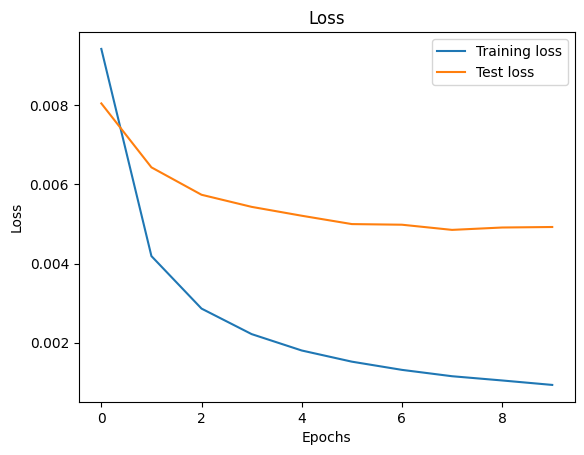

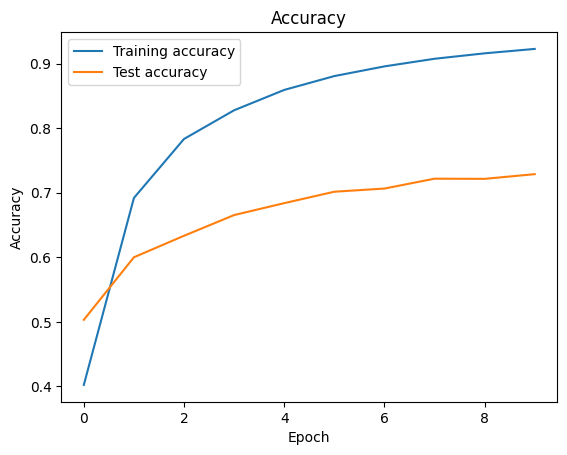

([0.009424924823405822,
  0.004189139329675658,
  0.0028621998625511505,
  0.002217293655307001,
  0.001802962139284573,
  0.0015208784573953246,
  0.001313454354246175,
  0.0011527812627970075,
  0.0010455737376872274,
  0.0009329837045536159],
 [0.008047817704174781,
  0.006431606879933449,
  0.005739013419596871,
  0.005433146104344648,
  0.005209005213625682,
  0.0049980859398322,
  0.0049819178714281395,
  0.004851371235364761,
  0.004911290750843114,
  0.00492423522219518],
 [0.4022924912400165,
  0.6920316068717992,
  0.7833907874764154,
  0.8278503638762396,
  0.8593579322182974,
  0.8808216651771148,
  0.8958306734193018,
  0.907633598615426,
  0.9160743924756352,
  0.9228979586046445],
 [0.503196579025361,
  0.6000677420720606,
  0.6333883737668826,
  0.6654811804056057,
  0.6839408950421271,
  0.7016385113679665,
  0.7065498115923621,
  0.7218341166010416,
  0.7215800838308142,
  0.7288623565773318])

In [18]:
model = FeatureMLPNet()
model.to(device)

learning_rate = 0.001
epochs = 10

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

run_training(model, criterion, optimizer, epochs)

In [19]:
class DirectMLPNet(nn.Module):
	def __init__(self):
		super(DirectMLPNet, self).__init__()
		
		self.fc1 = nn.Linear(in_features=3072, out_features=1024)
		self.fc2= nn.Linear(in_features=1024, out_features=512)
		self.fc3 = nn.Linear(in_features=512, out_features=256)
		self.fc4 = nn.Linear(in_features=256, out_features=141)

		self.relu = nn.ReLU()

		self.dropout = nn.Dropout(p=0.2)

	def forward(self, x):
		x = x.view(x.size(0), -1)
		x = self.fc1(x)
		x = self.relu(x)
		x = self.dropout(x)
		x = self.fc2(x)
		x = self.relu(x)
		x = self.dropout(x)
		x = self.fc3(x)
		x = self.relu(x)
		x = self.dropout(x)
		x = self.fc4(x)
		
		return x

In [20]:
training_data = CustomDataset(train_imgs, train_labels, transform=transform)
testing_data = CustomDataset(test_imgs, test_labels, transform=transform)

train_loader = DataLoader(training_data, batch_size=256, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=256, shuffle=True)

Epoch: 0 Train Loss: 0.0047 Train Acc: 0.6698 Test Loss: 0.0020 Test Acc: 0.8700
Epoch: 1 Train Loss: 0.0006 Train Acc: 0.9499 Test Loss: 0.0014 Test Acc: 0.9192
Epoch: 2 Train Loss: 0.0003 Train Acc: 0.9717 Test Loss: 0.0014 Test Acc: 0.9266
Epoch: 3 Train Loss: 0.0003 Train Acc: 0.9766 Test Loss: 0.0013 Test Acc: 0.9325
Epoch: 4 Train Loss: 0.0002 Train Acc: 0.9805 Test Loss: 0.0013 Test Acc: 0.9319


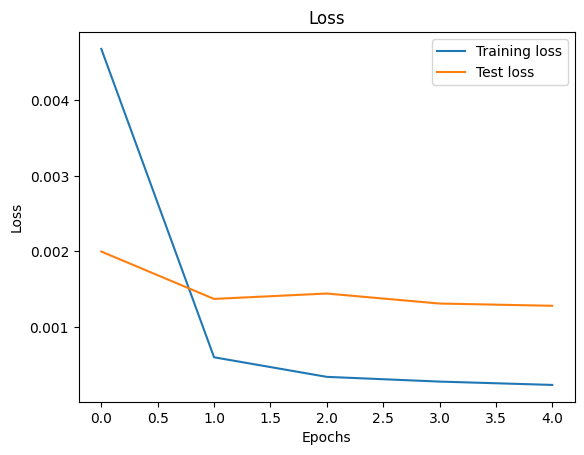

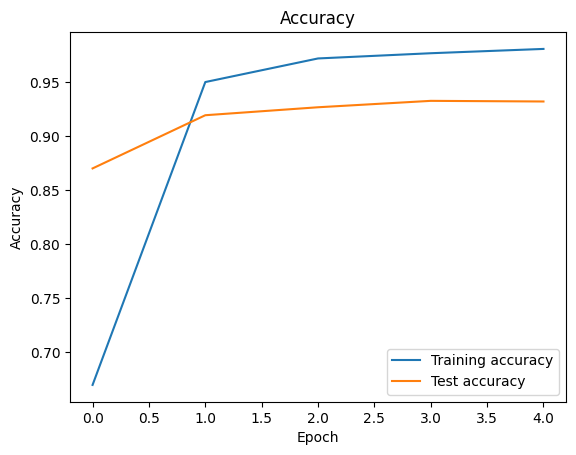

([0.004680210932719533,
  0.0005972003629109154,
  0.0003380347331560275,
  0.00027541412739423376,
  0.00023123908255154822],
 [0.0019970845680766973,
  0.0013700913169593057,
  0.001441374358029969,
  0.001308881281680876,
  0.0012791011123023503],
 [0.6698018186718872,
  0.9498943127491453,
  0.9717268871203416,
  0.976550197897604,
  0.9805365223929295],
 [0.8700198992336678,
  0.9192175790676997,
  0.9265845294042931,
  0.9325119607095982,
  0.9319192175790677])

In [21]:
model = DirectMLPNet()
model.to(device)

learning_rate = 0.001
epochs = 5

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

run_training(model, criterion, optimizer, epochs)

In [22]:
class EmptyNorm(nn.Module):
    def __init__(self, *args, **kwargs):
        super(EmptyNorm, self).__init__()
        self._modules = dict()
    
    def forward(self, input):
        return input

In [23]:
def conv3x3(in_planes, out_planes, stride=1, padding=1):
    """
    3x3 2D convolution with padding=1
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    @:param padding: the padding to apply, default is 1 to keep width and height the same in the output activation maps 
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """
    1x1 2D convolution
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


In [24]:
class ConvBlock(nn.Module):
    def __init__(self, bottleneck_channels, block_channels, norm_layer=nn.BatchNorm2d):
        super(ConvBlock, self).__init__()

        # first conv 1x1 layer which implements the bottlenecking
        self.conv1 = conv1x1(block_channels, bottleneck_channels)
        self.norm1 = norm_layer(bottleneck_channels)

        # conv 3x3 layer which applies the stride given as parameter
        self.conv2 = conv3x3(bottleneck_channels, bottleneck_channels)
        self.norm2 = norm_layer(bottleneck_channels)

        # conv 1x1 layer where the number of output channels is "expanded" according to the defined expansion factor
        # according to the above figure, the expansion factor is set to 4
        self.conv3 = conv1x1(bottleneck_channels, block_channels)
        self.norm3 = norm_layer(block_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        # first layer conv1 + bn1 + relu
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)

        # second layer conv2 + bn2 + relu
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)

        # third layer conv3 + bn3
        out = self.conv3(out)
        out = self.norm3(out)

        # add identity to residual and apply relu
        out += identity
        out = self.relu(out)

        return out

In [25]:
class DeepConvNet(nn.Module):
    def __init__(self, norm_layer=nn.BatchNorm2d, base_depth=16, expansion=4, nr_layer_blocks=3, num_classes=141):
        super(DeepConvNet, self).__init__()

        self.norm_layer = norm_layer
        self.base_depth = base_depth
        self.conv1 = nn.Conv2d(3, self.base_depth, kernel_size=7, stride=2, padding=3,
                               bias=False)  # image is now 16x16
        self.norm1 = norm_layer(self.base_depth)
        self.relu = nn.ReLU(inplace=True)

        # change to 64 channels base and image size 16x16
        depth1 = self.base_depth * expansion
        self.conv_depth1 = conv1x1(self.base_depth, depth1, stride=1)
        self.norm_depth1 = norm_layer(depth1)

        # #### Layer 1, 3 blocks
        self.layer1 = nn.Sequential(
            *[ConvBlock(self.base_depth, depth1, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # change to 128 channels base and image size 8x8
        depth2 = depth1 * 2
        # TODO 3.1 - Definiti convolutia 2D cu kernel de dimensiune 1x1 care injumatateste imaginea
        self.conv_depth2 = conv1x1(depth1, depth2, stride=2)
        self.norm_depth2 = norm_layer(depth2)

        # #### Layer 2, 3 blocks
        # TODO 3.2 - Definiti secventa de ConvBlocks pentru Layer 2
        self.layer2 = nn.Sequential(
            *[ConvBlock(depth1, depth2, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # change to 256 chanels and image size 4x4
        depth3 = depth2 * 2
        # TODO 3.3 - Definiti convolutia 2D cu kernel de dimensiune 1x1 care injumatateste imaginea
        self.conv_depth3 = conv1x1(depth2, depth3, stride=2)
        self.norm_depth3 = norm_layer(depth3)

        # Layer 3, 3 blocks
        # TODO 3.4 - Definiti secventa de ConvBlocks pentru Layer 3
        self.layer3 = nn.Sequential(
            *[ConvBlock(depth2, depth3, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # AveragePooling
        # TODO 3.5 - Definiti straturile de GlobalAveragePooling si stratul Fully Connected
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(depth3, num_classes)


    def forward(self, x):
        # initial conv
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        # TODO 3.6 apply depth1 transform + layer 1
        x = self.conv_depth1(x)
        x = self.norm_depth1(x)
        x = self.relu(x)
        x = self.layer1(x)      

        # TODO 3.7 apply depth2 transform + layer 2
        x = self.conv_depth2(x)
        x = self.norm_depth2(x)
        x = self.relu(x)
        x = self.layer2(x)

        # TODO 3.8 apply depth3 transform + layer 3
        x = self.conv_depth3(x)
        x = self.norm_depth3(x)
        x = self.relu(x)
        x = self.layer3(x)
        
        # apply global average pooling + linearize + FC
        x = self.avgpool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

In [26]:
training_data = CustomDataset(train_imgs, train_labels, transform=transform)
testing_data = CustomDataset(test_imgs, test_labels, transform=transform)

train_loader = DataLoader(training_data, batch_size=256, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=256, shuffle=True)

In [27]:
model = DeepConvNet()
model.to(device)

learning_rate = 0.001
epochs = 20

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

run_training(model, criterion, optimizer, epochs)

Epoch: 0 Train Loss: 0.0031 Train Acc: 0.8203 Test Loss: 0.0204 Test Acc: 0.1182
Epoch: 1 Train Loss: 0.0003 Train Acc: 0.9851 Test Loss: 0.0204 Test Acc: 0.1685
Epoch: 2 Train Loss: 0.0001 Train Acc: 0.9928 Test Loss: 0.0230 Test Acc: 0.1499
Epoch: 3 Train Loss: 0.0002 Train Acc: 0.9884 Test Loss: 0.0203 Test Acc: 0.1975
Epoch: 4 Train Loss: 0.0001 Train Acc: 0.9966 Test Loss: 0.0185 Test Acc: 0.2546
Epoch: 5 Train Loss: 0.0001 Train Acc: 0.9958 Test Loss: 0.0215 Test Acc: 0.1664


KeyboardInterrupt: 

In [ ]:
hard_transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.RandomHorizontalFlip(),
	transforms.RandomRotation(10),
	transforms.RandomCrop(32, padding=int(32*0.125), padding_mode='reflect'),
	transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
training_data = CustomDataset(train_imgs, train_labels, transform=hard_transform)
testing_data = CustomDataset(test_imgs, test_labels, transform=transform)

train_loader = DataLoader(training_data, batch_size=256, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=256, shuffle=True)

In [ ]:
model = DeepConvNet()
model.to(device)

learning_rate = 0.001
epochs = 20

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

run_training(model, criterion, optimizer, epochs)

In [ ]:
resnet_transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Resize((32, 32)),
	transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
class MyConvNet(nn.Module):
	def __init__(self):
		super(MyConvNet, self).__init__()

		self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

		self.norm1 = nn.BatchNorm2d(32)
		self.pool1 = nn.MaxPool2d(kernel_size=2)
		self.dropout1 = nn.Dropout(0.25)

		self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
		self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

		self.norm2 = nn.BatchNorm2d(64)
		self.pool2 = nn.MaxPool2d(kernel_size=2)
		self.dropout2 = nn.Dropout(0.25)

		self.fc1 = nn.Linear(64 * 32 * 32, 512)
		self.fc2 = nn.Linear(512, 141)

		self.activation = nn.ReLU()

	def forward(self, x):
		x = self.activation(self.conv1(x))

		x = self.activation(self.conv2(x))

		x = self.norm1(x)
		x = self.pool1(x)
		x = self.dropout1(x)

		x = self.activation(self.conv3(x))
		x = self.activation(self.conv4(x))

		x = self.norm2(x)
		x = self.pool2(x)
		x = self.dropout2(x)

		x = x.view(-1, 64 * 32 * 32)

		x = self.activation(self.fc1(x))
		x = self.fc2(x)

		return x

In [ ]:
training_data = CustomDataset(train_imgs, train_labels, transform=resnet_transform)
testing_data = CustomDataset(test_imgs, test_labels, transform=resnet_transform)

train_loader = DataLoader(training_data, batch_size=256, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=256, shuffle=True)

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 141)
model.to(device)

lr_init = 0.001
lr_factor = 0.1
weight_decay_factor = 1e-4
lr_schedule_milestones = [50e3, 75e3, 100e3]
epochs = 20

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

run_training(model, criterion, optimizer, epochs, lr_scheduler)